In [1]:
from __future__ import division, print_function
import numpy as np
from scipy import interpolate,integrate,fftpack
import pyfits
import plotc
import read_params
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker,gridspec
from scipy.special import j1,j0,jn
def j2(z): return jn(2,z)
def j1prime(z): return 0.5*(j0(z)-j2(z))
import os,shutil,fnmatch,itertools
import dbyd2
%matplotlib inline

Lx = read_params.get_xlength()
nx = read_params.get_nx()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False);dx=x[1]-x[0]
Rsun=6.95989467700E2
z,c_sound,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[0,1,2],unpack=True); z=(z-1)*Rsun;c_sound/=100;

def ddz(z_profile):
    darr = dbyd2.dbyd2(np.asfortranarray(np.atleast_2d(z_profile)),1)
    dz2d = dbyd2.dbyd2(np.asfortranarray(np.atleast_2d(z)),1)
    return np.squeeze(darr/dz2d)

def fitsread(f): return np.squeeze(pyfits.getdata(f))

RDH13 = 15
kDH13 = 2*np.pi/(2*RDH13)

datadir_list = [os.path.join(os.path.dirname(read_params.get_directory()),
                             "spline_SG{:d}".format(sgno)) for sgno in xrange(1,5)]

home = os.environ["HOME"]
codedir_list = [os.path.join(home,"sparc_SG{:d}".format(sgno)) for sgno in xrange(1,5)]

## Fitted models

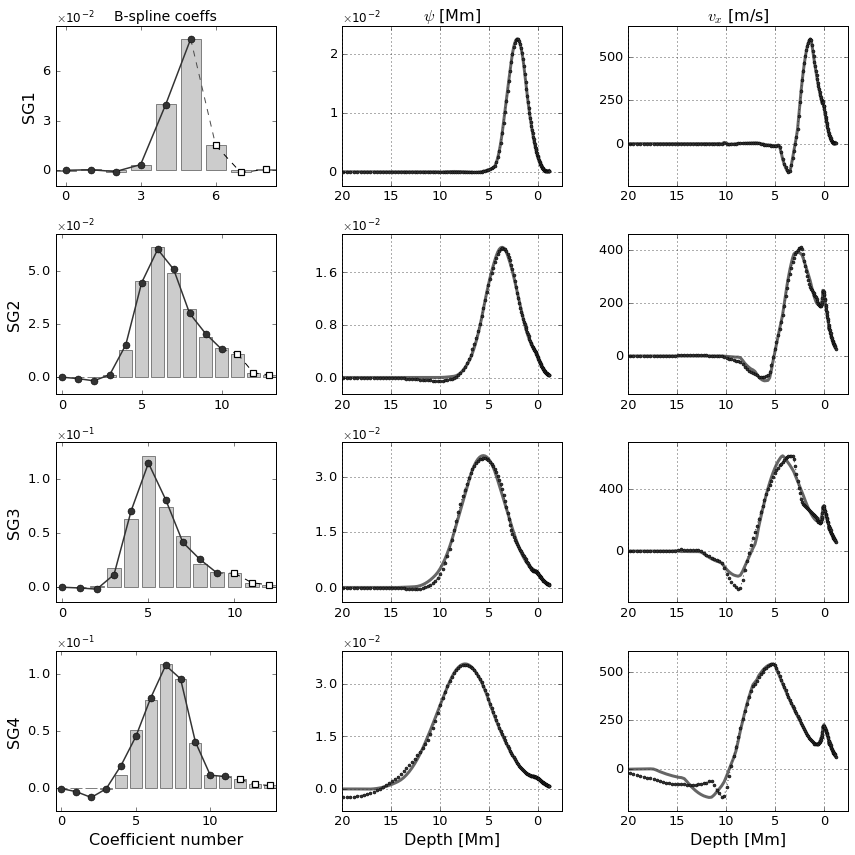

In [2]:
f=plt.figure()
f.set_size_inches(12,3*len(datadir_list));
ncols = 3

def remove_neg(x,pos):
    return '{:.0f}'.format(abs(float(x)))

for modelno,(codedir,datadir) in enumerate(zip(codedir_list,datadir_list)):
    
    plt.subplot(len(datadir_list),ncols,modelno*ncols+1)

    coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "model_psi_[0-9][0-9]_coeffs.npz"))
    vx_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "vx_[0-9][0-9].fits"))

    spline_basis_coeffs = [np.load(os.path.join(datadir,"update",f)) for f in coeff_files]
    spline_basis_z = [s["z"] for s in spline_basis_coeffs]

    true_coeffs = np.load(os.path.join(datadir,"true_psi_coeffs.npz"))
    true_coeffs_z = true_coeffs["cz_bot"]
    true_coeffs_top = true_coeffs["cz_top"]
    c_surf_cutoff = true_coeffs['c_surf_cutoff']

    iterno = min(len(spline_basis_z),len(vx_files))-1

    plt.plot(spline_basis_z[iterno][:c_surf_cutoff],ls="solid",
    marker="o",markersize=7,label="Iterated",
    color="0.2",lw=1.5,zorder=4)

    bridge = [spline_basis_z[iterno][c_surf_cutoff-1],true_coeffs_top[c_surf_cutoff]]

    plt.plot(np.arange(c_surf_cutoff-1,c_surf_cutoff+1),
    bridge,ls="dashed",color='0.3',lw=1,zorder=3)

    plt.plot(np.arange(c_surf_cutoff,true_coeffs_top.size-3),
    true_coeffs_top[c_surf_cutoff:-3],ls="dashed",marker='s',ms=6,color='black',
    mec='black',mfc="white",lw=1,zorder=3,mew=1.2,
    label="Clamped")

    plt.gca().margins(y=0.1)

    plt.bar(np.arange(true_coeffs_z.size-3)-0.4,(true_coeffs_z+true_coeffs_top)[:-3],width=0.8,
            facecolor="0.8",edgecolor="0.5",label="Reference"
            ,zorder=1)   
    
    plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.tick_params(labelsize=13,axis="both")
    plt.gca().yaxis.get_offset_text().set_fontsize(12)
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.get_major_formatter().set_powerlimits((0,3))
    
    # psi and v sections
    
    true_psi = fitsread(os.path.join(codedir,'true_psi.fits'))
    current_psi = fitsread(os.path.join(datadir,'update',
                    'model_psi_{:02d}.fits'.format(iterno)))
    current_psi = current_psi-current_psi[0,0]

    true_vx = fitsread(os.path.join(codedir,'true_vx.fits'))
    true_vz = fitsread(os.path.join(codedir,'true_vz.fits'))

    current_vx = fitsread(
    os.path.join(datadir,'update','vx_{:02d}.fits'.format(iterno)))

    current_vz = fitsread(
    os.path.join(datadir,'update','vz_{:02d}.fits'.format(iterno)))
    
    psi_max_row_index,psi_max_col_index = divmod(true_psi.argmax(),nx)
    curpsi_max_row_index,curpsi_max_col_index = divmod(current_psi.argmax(),nx)

    vx_max_row_index,vx_max_col_index = divmod(true_vx.argmax(),nx)
    curvx_max_row_index,curvx_max_col_index = divmod(current_vx.argmax(),nx)

    vz_max_row_index,vz_max_col_index = divmod(true_vz.argmax(),nx)
    curvz_max_row_index,curvz_max_col_index = divmod(current_vz.argmax(),nx)

    ref_color="0.4"
    iter_color="0.2"
    
    plt.subplot(len(datadir_list),ncols,modelno*ncols+2)
    plt.plot(z,true_psi[:,curpsi_max_col_index],label="Reference",
             color=ref_color,linewidth=3)
    plt.plot(z,current_psi[:,curpsi_max_col_index],label="Iterated",
    linewidth=1,color=iter_color,ls="dotted",marker='o',ms=3)
    plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.get_major_formatter().set_powerlimits((0,3))
    plt.tick_params(labelsize=13,axis="both")
    plt.gca().yaxis.get_offset_text().set_fontsize(12)
    plt.xlim(-20,2.5)        
    plt.margins(y=0.1)
    plt.grid(color="0.2",linewidth=0.8)

    plt.subplot(len(datadir_list),ncols,modelno*ncols+3)
    plt.plot(z,true_vx[:,curvx_max_col_index],label="Reference",
             color=ref_color,linewidth=3)
    plt.plot(z,current_vx[:,curvx_max_col_index],label="Iterated",
    linewidth=1,color=iter_color,ls="dotted",marker='o',ms=3)
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.get_major_formatter().set_powerlimits((0,3))
    plt.tick_params(labelsize=13,axis="both")
    plt.gca().yaxis.get_offset_text().set_fontsize(12)
    plt.xlim(-20,2.5)
    plt.margins(y=0.1)
    plt.grid(color="0.2",linewidth=0.8)

plt.subplot(len(datadir_list),ncols,1)
plt.title("B-spline coeffs",fontsize=14)

for modelno,datadir in enumerate(datadir_list):
    plt.subplot(len(datadir_list),ncols,ncols*modelno+1)
    plt.ylabel("SG{:d}".format(modelno+1),fontsize=16)

plt.subplot(len(datadir_list),ncols,2)
plt.title(r"$\psi$ [Mm]",fontsize=16)

plt.subplot(len(datadir_list),ncols,3)
plt.title(r"$v_x$ [m/s]",fontsize=16)

plt.subplot(len(datadir_list),ncols,ncols*(len(datadir_list)-1)+1)
plt.xlabel("Coefficient number",fontsize=16)

plt.subplot(len(datadir_list),ncols,ncols*(len(datadir_list)-1)+2)
plt.xlabel("Depth [Mm]",fontsize=16)

plt.subplot(len(datadir_list),ncols,ncols*(len(datadir_list)-1)+3)
plt.xlabel("Depth [Mm]",fontsize=16)

plt.tight_layout()
plt.gcf().subplots_adjust(hspace=0.3,wspace=0.3)

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/f3.eps")

## Peak depths

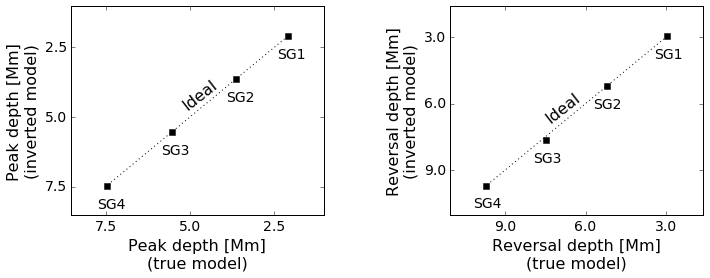

In [7]:
f=plt.figure()
f.set_size_inches(10,4)

peak_depths_ref = []
peak_depths_iter = []

reversal_depths_ref = []
reversal_depths_iter = []

for modelno,(codedir,datadir) in enumerate(zip(codedir_list,datadir_list)):
    
    coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "model_psi_[0-9][0-9].fits"))
    vx_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "vx_[0-9][0-9].fits"))
    
    iterno = min(len(coeff_files),len(vx_files))-1
    
    true_psi = fitsread(os.path.join(codedir,'true_psi.fits'))
    current_psi = fitsread(os.path.join(datadir,'update',
                    'model_psi_{:02d}.fits'.format(iterno)))
    current_psi = current_psi-current_psi[0,0]
    
    psi_max_row_index,psi_max_col_index = divmod(true_psi.argmax(),nx)
    curpsi_max_row_index,curpsi_max_col_index = divmod(current_psi.argmax(),nx)

    peak_depths_ref.append(z[true_psi[:,curpsi_max_col_index].argmax()])
    peak_depths_iter.append(z[current_psi[:,curpsi_max_col_index].argmax()])
    
    true_vx = fitsread(os.path.join(codedir,'true_vx.fits'))
    current_vx = fitsread(os.path.join(datadir,'update',
                    'vx_{:02d}.fits'.format(iterno)))
    
    vx_max_row_index,vx_max_col_index = divmod(true_vx.argmax(),nx)
    curvx_max_row_index,curvx_max_col_index = divmod(current_vx.argmax(),nx)
    
    vx_ref_vert_profile = true_vx[:,vx_max_col_index]
    vx_ref_vert_profile[z<-20]=0
    vx_iter_vert_profile = current_vx[:,curvx_max_col_index]
    vx_iter_vert_profile[z<-20]=0
    
    reversal_depths_ref.append(z[np.where(np.diff(np.sign(vx_ref_vert_profile)))[0][-1]])
    reversal_depths_iter.append(z[np.where(np.diff(np.sign(vx_iter_vert_profile)))[0][-1]])
    
def remove_neg(x,pos):
    return '{:.1f}'.format(abs(float(x)))

plt.subplot(121)

plt.plot(peak_depths_ref,peak_depths_iter,marker='s',color='black',ls="None",ms=6)
plt.plot(peak_depths_ref,peak_depths_ref,color='black',ls="dotted")

# plt.xticks(peak_depths_ref)
# plt.yticks(peak_depths_iter)
    
plt.xlabel("Peak depth [Mm]\n(true model)",fontsize=16)
plt.ylabel("Peak depth [Mm]\n(inverted model)",fontsize=16)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
plt.tick_params(labelsize=14)
plt.margins(x=0.2,y=0.2)

plt.text(-5.3,-4,"Ideal",fontsize=16,rotation=38)
for modelno,(x_text,y_text) in enumerate(zip(peak_depths_ref,peak_depths_iter)):
    plt.text(x_text-0.3,y_text-0.8,"SG{:d}".format(modelno+1),fontsize=14)

plt.subplot(122)

plt.plot(reversal_depths_ref,reversal_depths_iter,marker='s',color='black',ls="None",ms=6)
plt.plot(reversal_depths_ref,reversal_depths_ref,color='black',ls="dotted")

# plt.xticks(reversal_depths_ref)
# plt.yticks(reversal_depths_iter)
    
plt.xlabel("Reversal depth [Mm]\n(true model)",fontsize=16)
plt.ylabel("Reversal depth [Mm]\n(inverted model)",fontsize=16)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
plt.tick_params(labelsize=14)
plt.margins(x=0.2,y=0.2)

plt.text(-7.6,-5.9,"Ideal",fontsize=16,rotation=38)
for modelno,(x_text,y_text) in enumerate(zip(reversal_depths_ref,reversal_depths_iter)):
    plt.text(x_text-0.5,y_text-1,"SG{:d}".format(modelno+1),fontsize=14)

plt.tight_layout()
f.subplots_adjust(wspace=0.5)

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/f4.eps")

## SG2 inverted model and misfit

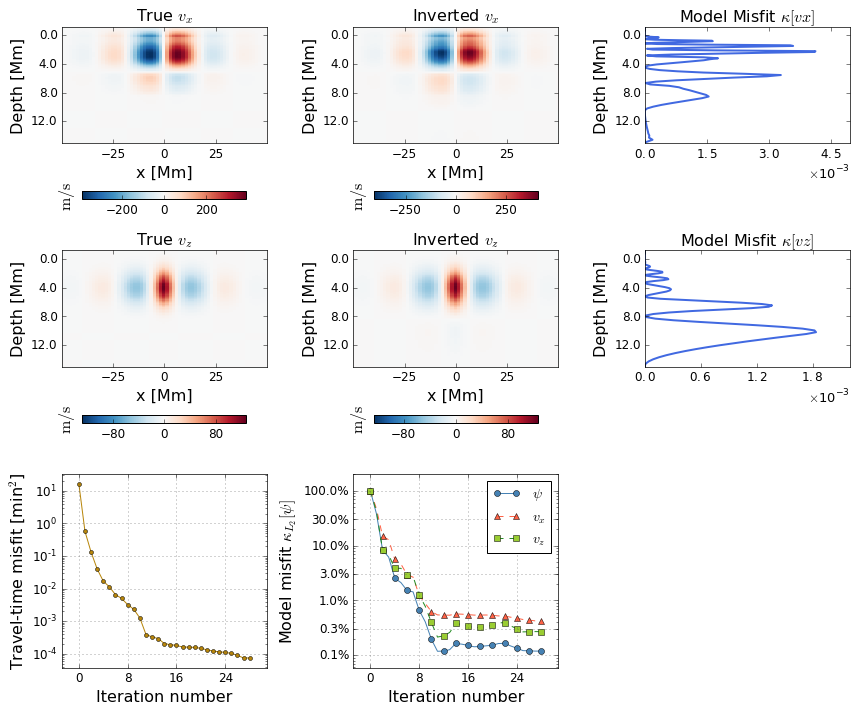

In [30]:
f=plt.figure()
f.set_size_inches(12,10)

modelno = 1
datadir = datadir_list[modelno]
codedir = codedir_list[modelno]

coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "model_psi_[0-9][0-9].fits"))

vx_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "vx_[0-9][0-9].fits"))

iterno = min(len(coeff_files),len(vx_files))-1

true_vx = fitsread(os.path.join(codedir,'true_vx.fits'))
true_vz = fitsread(os.path.join(codedir,'true_vz.fits'))
current_vx = fitsread(os.path.join(datadir,'update','vx_{:02d}.fits'.format(iterno)))
current_vz = fitsread(os.path.join(datadir,'update','vz_{:02d}.fits'.format(iterno)))

x_plot = np.append(x-dx/2,x[-1]+dx/2)

def remove_neg(x,pos):
    return '{:.1f}'.format(abs(float(x)))

axlist = {}
cblist = {}
def add_subplot(sp_index,array,title=""):
    ax=plt.subplot(sp_index)
    array_max = abs(array).max()
    qm=ax.pcolormesh(x_plot,z,array,vmax=array_max,vmin=-array_max,cmap="RdBu_r",rasterized=True)
    cb=plt.colorbar(mappable=qm,orientation="horizontal",shrink=0.8,pad=0.25,ticks=ticker.MaxNLocator(4))
    plt.title(title,y=1.01,fontsize=16)
    ax.set_xlim(-50,50)
    ax.set_ylim(-15,z.max())
    ax.set_xlabel("x [Mm]",fontsize=16)
    ax.set_ylabel("Depth [Mm]",fontsize=16)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4,prune="both"))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5,prune="both"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
    ax.tick_params(axis='both',labelsize=12)
    axlist[sp_index]=ax
    cblist[sp_index]=cb

add_subplot(331,true_vx,title="True $v_x$")
add_subplot(332,current_vx,title="Inverted $v_x$")
add_subplot(333,true_vx)
add_subplot(334,true_vz,title="True $v_z$")
add_subplot(335,current_vz,title="Inverted $v_z$")    
add_subplot(336,true_vz)
    
for cb in cblist.values(): 
    cb.ax.set_ylabel(r"$\mathrm{m}/\mathrm{s}$",rotation=90,fontsize=16)
    cb.ax.tick_params(axis="x",labelsize=12)

misfitfiles=sorted([os.path.join(datadir,"update",f) for f in 
                    fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                                   'misfit_[0-9][0-9]')])

total_misfit = np.zeros(len(misfitfiles))
for fileno,misfitfile in enumerate(misfitfiles):
    total_misfit[fileno] = np.sum(np.loadtxt(misfitfile,usecols=[2]))

    
axlist[337]=plt.subplot(337)
plotdict = dict(color='darkgoldenrod',marker='o',ls='solid',zorder=1,markevery=1,ms=4)
plt.semilogy(range(len(misfitfiles)),total_misfit,**plotdict)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel('Travel-time misfit [min$^2$]',fontsize=16)
plt.xlabel("Iteration number",fontsize=16)
plt.margins(x=0.1)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6,integer=True,prune="lower"))
plt.ylim(min(total_misfit)/2,max(total_misfit)*2)
plt.grid(color="0.3")

axlist[338]=plt.subplot(338)
with np.load(os.path.join(datadir,'true_psi_coeffs.npz')) as f:
    tz = f['tz']
    cz_top = f['cz_top']
    cz_true = f['cz_top']+f['cz_bot']
    kz = f['kz']

psi_true = interpolate.splev(z,(tz,cz_true,kz),ext=1)
psi_start = interpolate.splev(z,(tz,cz_top,kz),ext=1)

psi_norm = integrate.simps((psi_true-psi_start)**2,x=z)
vz_norm = integrate.simps(c_sound**2*(psi_true-psi_start)**2,x=z)
vx_norm = integrate.simps(1/rho**2*ddz(rho*c_sound*(psi_true-psi_start))**2,x=z)

misfit_psi = []
misfit_vx = []
misfit_vz = []

for iterno in xrange(len(misfitfiles)):
    with np.load(os.path.join(datadir,'update',
        'model_psi_{:02d}_coeffs.npz'.format(iterno))) as f:
        cz_model = f['z'] + cz_top
        psi_model = interpolate.splev(z,(tz,cz_model,kz),ext=1)

    misfit_psi_i = integrate.simps((psi_true-psi_model)**2,x=z)/psi_norm
    misfit_psi.append(misfit_psi_i)

    misfit_vz_i = integrate.simps(c_sound**2*(psi_true-psi_model)**2,x=z)/vz_norm
    misfit_vz.append(misfit_vz_i)

    misfit_vx_i = integrate.simps(1/rho**2*ddz(rho*c_sound*(psi_true-psi_model))**2,x=z)/vx_norm
    misfit_vx.append(misfit_vx_i)

psi_misfit_line, = axlist[338].semilogy(misfit_psi,linestyle='solid',marker='o',
                     label="$\psi$",color='steelblue',zorder=1,markevery=2)
vx_misfit_line,=axlist[338].semilogy(misfit_vx,linestyle='dashed',marker='^',
                     label="$v_x$",color='tomato',zorder=1,markevery=2)
vz_misfit_line,=axlist[338].semilogy(misfit_vz,linestyle='dashed',marker='s',
                     label="$v_z$",mfc='yellowgreen',zorder=1,color="forestgreen",markevery=2)

plt.gca().yaxis.set_major_locator(ticker.LogLocator(subs=[1,3]))
def percent(y,position):
    s = "{:}".format(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(percent))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6,integer=True,prune="lower"))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel(r"Model misfit $\kappa_{L_2}[\psi]$",fontsize=16)
plt.xlabel("Iteration number",fontsize=16)

plt.grid(color="0.3");
plt.legend(loc="best",fontsize=14);
axlist[338].set_ylim(min(min(misfit_vz),min(misfit_vx),min(misfit_psi))/2,2)
axlist[338].margins(x=0.1)

with np.load(os.path.join(datadir,'update',
    'model_psi_{:02d}_coeffs.npz'.format(len(misfitfiles)-1))) as f:
    cz_model = f['z'] + cz_top
    psi_model = interpolate.splev(z,(tz,cz_model,kz),ext=1)

misfit_vz_scale = (abs(psi_true*c_sound).max())**2
misfit_vz = (psi_true-psi_model)**2*c_sound**2

misfit_vx_scale = (abs(ddz(rho*c_sound*psi_true)/rho).max())**2
misfit_vx = (ddz(rho*c_sound*(psi_true-psi_model))**2)/rho**2

axlist[333].cla()
axlist[336].cla()

axlist[333].set_rasterized(False)
axlist[333].plot(misfit_vx/misfit_vx_scale,z,color="royalblue",lw=2,zorder=1)
axlist[333].set_ylim(axlist[332].set_ylim())
axlist[333].yaxis.set_major_locator(axlist[332].yaxis.get_major_locator())
axlist[333].yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
axlist[333].xaxis.set_major_locator(ticker.MaxNLocator(4))
axlist[333].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
axlist[333].xaxis.get_offset_text().set_fontsize(13)
axlist[333].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
axlist[333].set_title(r"Model Misfit $\kappa[vx]$",fontsize=16)
axlist[333].set_xlim(0,axlist[333].get_xlim()[1]*1.1)
axlist[333].set_ylabel("Depth [Mm]",fontsize=16)

axlist[336].set_rasterized(False)
axlist[336].plot(misfit_vz/misfit_vz_scale,z,color="royalblue",lw=2)
axlist[336].set_ylim(axlist[335].set_ylim())
axlist[336].yaxis.set_major_locator(axlist[335].yaxis.get_major_locator())
axlist[336].yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
axlist[336].xaxis.set_major_locator(ticker.MaxNLocator(4))
axlist[336].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
axlist[336].xaxis.get_offset_text().set_fontsize(13)
axlist[336].ticklabel_format(axis="x",style="sci",scilimits=(0,0))
axlist[336].set_title(r"Model Misfit $\kappa[vz]$",fontsize=16)
axlist[336].set_xlim(0,axlist[336].get_xlim()[1]*1.1)
axlist[336].set_ylabel("Depth [Mm]",fontsize=16)

plt.tight_layout()

cblist[333].ax.set_visible(False)
cblist[336].ax.set_visible(False)

[plt.setp(ax.spines.values(), linewidth=0.7) for ax in axlist.values()]

# axlist[339]=plt.subplot(339)
# datadir_list_mc = [datadir]
# datadir_list_mc.extend([datadir+"_morecoeffs{:d}".format(i) for i in xrange(1,4)])
# vx_misfits = np.zeros(len(datadir_list_mc))
# psi_misfits = np.zeros(len(datadir_list_mc))
# vz_misfits = np.zeros(len(datadir_list_mc))
# N_coeffs = np.zeros_like(vx_misfits)
# for datadirno,datadir in enumerate(datadir_list_mc):
#     f= np.load(os.path.join(datadir,"true_psi_coeffs.npz"))
#     tz = f['tz']
#     cz_top = f['cz_top']
#     cz_true = f['cz_top']+f['cz_bot']
#     kz = f['kz']
#     N_coeffs[datadirno] = tz.size-kz-1
    
#     vx_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
#                     "vx_[0-9][0-9].fits"))
#     iterno = len(vx_files)-1
#     with np.load(os.path.join(datadir,'update',
#         'model_psi_{:02d}_coeffs.npz'.format(iterno))) as f:
#         cz_model = f['z'] + cz_top
#         psi_model = interpolate.splev(z,(tz,cz_model,kz),ext=1)
    
#     psi_true = interpolate.splev(z,(tz,cz_true,kz),ext=1)
#     vx_norm = integrate.simps(1/rho**2*ddz(rho*c_sound*psi_true)**2,x=z)
    
#     misfit_psi_i = integrate.simps((psi_true-psi_model)**2,x=z)/psi_norm
#     psi_misfits[datadirno]=misfit_psi_i

#     misfit_vz_i = integrate.simps(c_sound**2*(psi_true-psi_model)**2,x=z)/vz_norm
#     vz_misfits[datadirno]=misfit_vz_i
    
#     misfit_vx_i = integrate.simps(1/rho**2*ddz(rho*c_sound*(psi_true-psi_model))**2,x=z)/vx_norm
#     vx_misfits[datadirno] = misfit_vx_i

# axlist[339].plot(N_coeffs,psi_misfits,marker=psi_misfit_line.get_marker(),ms=6,ls='dashed',
#                  color=psi_misfit_line.get_color(),label="$\psi$",
#                  mfc=psi_misfit_line.get_markerfacecolor())
# axlist[339].plot(N_coeffs,vx_misfits,marker=vx_misfit_line.get_marker(),
#                  ms=6,ls='dashed',color=vx_misfit_line.get_color(),label="$v_x$",
#                  mfc=vx_misfit_line.get_markerfacecolor())
# axlist[339].plot(N_coeffs,vz_misfits,marker=vz_misfit_line.get_marker(),
#                  ms=6,ls='dashed',color=vz_misfit_line.get_color(),label="$v_z$",
#                  mfc=vz_misfit_line.get_markerfacecolor())
# axlist[339].margins(x=0.1,y=0.1)
# axlist[339].set_xlabel("Number of coefficients",fontsize=16)
# axlist[339].set_ylabel("Model misfit $\kappa_{L_2}[v_x]$",fontsize=16)
# axlist[339].yaxis.set_major_formatter(ticker.FuncFormatter(percent))
# axlist[339].xaxis.set_major_locator(ticker.MaxNLocator(5))
# plt.tick_params(axis='both', which='major', labelsize=12)
# plt.legend(loc="best",fontsize=14)

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/f2.eps")

## Travel-times

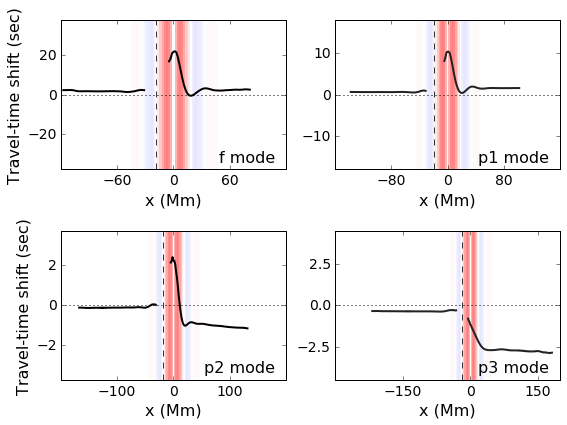

In [6]:
f=plt.figure()
f.set_size_inches(8,6)

datadir = datadir_list[1]
codedir = codedir_list[1]

src=2

datafile=os.path.join(datadir,'data',str(src).zfill(2)+'.fits')
data=fitsread(datafile)

masterpixelsfile=os.path.join(datadir,'master.pixels')
masterpixels=np.loadtxt(masterpixelsfile,ndmin=1)

def spaced(a):
    b=a[:-4]+" "+a[-4:]
    b=b.replace("_"," ")
    return b

vzcc=[]
vzcc_ridges=[]
iters=[]

srcloc=masterpixels[int(src)-1]
srcloc_ind=np.argmin(abs(x-srcloc))
srcloc=round(x[srcloc_ind],1)

modes={'0':'fmode'}
for pmodeno in xrange(1,8): modes.update({str(pmodeno):'p'+str(pmodeno)+'mode'})
    
paramsfiles=[os.path.splitext(paramfile)[1][1:] for paramfile in fnmatch.filter(os.listdir(datadir),'params.[0-9]')]
ridge_filters_driver=read_params.get_ridge_filter()
ridge_filters=sorted([ridge for ridge in ridge_filters_driver if ridge in paramsfiles])
    
ttdiff_ridges={}
for mode in modes: ttdiff_ridges.update({mode:{"iter_no":[],"misfits":[]}})
for iteration_no in xrange(0,100):
    ttpath=os.path.join(datadir,'tt','iter'+str(iteration_no).zfill(2))
    if os.path.exists(ttpath):
        for modeno,mode in enumerate(ridge_filters):
            ttfile=os.path.join(ttpath,'ttdiff_src{:02d}.'.format(src)+modes[mode]+'.0')
            if os.path.exists(ttfile):
                ttdiff_ridges[mode]["iter_no"].append(iteration_no)
                ttdiff_ridges[mode]["misfits"].append(np.loadtxt(ttfile))
                
c=itertools.cycle(['black','#222222'])

# vspans to indicate extent of flow
numspans = 40
spanedges = np.linspace(-3*RDH13,3*RDH13,numspans)
def vx_r_fn(x): return j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
vx_x = vx_r_fn(x)*np.sign(x)
norm = matplotlib.colors.Normalize(vx_x.min()*2, vx_x.max()*2)
my_cmap = matplotlib.cm.get_cmap("bwr")

# list of axes
axlist = []

labels=["starting","inverted"]

for modeno,mode in enumerate(ridge_filters[:8]):

    iters_to_plot_ridge = ttdiff_ridges[mode]["iter_no"]

    linestyles = itertools.cycle(('solid','dashed'))

    ax = f.add_subplot(3,3,modeno+1)
    axlist.append(ax)

    if len(iters_to_plot_ridge)>2:
        iters_to_plot_ridge= [iters_to_plot_ridge[i] for i in [0]]

    for color_index,iter_no in enumerate(iters_to_plot_ridge):

        index_of_iteration=ttdiff_ridges[mode]["iter_no"].index(iter_no)
        td=ttdiff_ridges[mode]["misfits"][index_of_iteration]
        td[:,0]-=1 # fortran index starts from 1, change to python zero based index

        left_pix=np.where(td[:,0]<srcloc_ind)[0]
        xcoords_left=np.take(x,td[left_pix,0].astype(int))
        right_pix=np.where(td[:,0]>srcloc_ind)[0]
        xcoords_right=np.take(x,td[right_pix,0].astype(int))

        #~ Points to the left
        skip_pix = 1
        ls = next(linestyles)
        color = next(c)
        p=ax.plot(xcoords_left[::skip_pix],-td[left_pix[::skip_pix],1],
                color=color,label=labels[color_index],
                linestyle=ls,linewidth=2,zorder=2)[0]

        #~ Points to the right
        ax.plot(xcoords_right[::skip_pix],-td[right_pix[::skip_pix],1],
        color=p.get_color(),linestyle=ls,linewidth=2,zorder=2)

    ax.text(0.95,0.05,spaced(modes[mode]),fontdict=dict(size=16),
            transform=ax.transAxes,horizontalalignment="right")
    ax.axhline(y=[0],ls='dotted',color='black')
    ax.axvline(x=srcloc,color='#333333',ls='dashed')

    ax.xaxis.set_major_locator(ticker.MaxNLocator(4,prune="both"))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5,prune='both'))
    ax.xaxis.set_tick_params(which='major', labelsize=14)
    ax.yaxis.set_tick_params(which='major', labelsize=14)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(-max(abs(ymin),abs(ymax))*1.5,max(abs(ymin),abs(ymax))*1.5)
#     ax.legend(loc="best",fontsize=12,ncol=2)

    for span_left,span_right in zip(spanedges[:-1],spanedges[1:]):
        span_color = my_cmap(norm(vx_r_fn((span_left+span_right)/2)))
        ax.axvspan(span_left,span_right,color=span_color,zorder=0)

        
for axno,ax in enumerate(axlist):
    ncols = min(2,len(axlist))
    nrows = int(np.ceil(len(axlist)/ncols))
    ax.change_geometry(nrows,ncols,axno+1)
    ax.set_xlabel("x (Mm)",fontsize=16)
    
axlist[0].set_ylabel("Travel-time shift (sec)",fontsize=16)
axlist[2].set_ylabel("Travel-time shift (sec)",fontsize=16)    

plt.tight_layout()

#~ Get filename to save to

savepath = os.path.join("plots","f1.eps")
if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig(savepath)

## B-splines

/home/jishnu/anaconda2/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


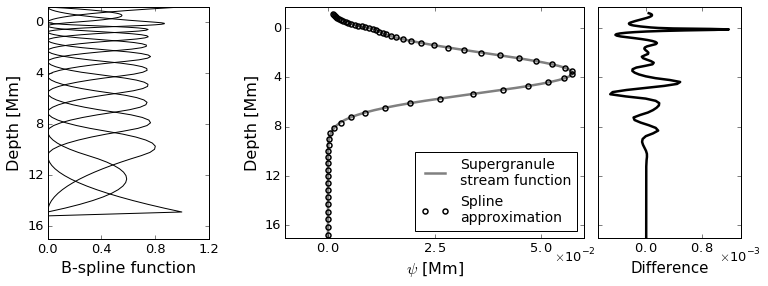

In [3]:
kDH13 = 2*np.pi/30
RDH13 = 15
sigmazDH13 = 1.6
z0DH13 = -4
v0DH13 = 270

z_cutoff = -15 # Spline lower cutoff
zspline_ind = z>z_cutoff
zspline = z[z>z_cutoff]

if not os.path.exists("plots"):
    os.makedirs("plots")

psi_z_profile = v0DH13/c_sound/kDH13*np.exp(-(z-z0DH13)**2/(2*sigmazDH13**2))

def coeff_to_model(tck_z):
    f0_x = np.sign(x)*j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
    h_z=interpolate.splev(z,tck_z,ext=1)
    return f0_x[None,:]*h_z[:,None]

s_misfit = []
s_list = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8]
Nparams = []
for s in s_list:
    tz1D,cz1D,kz=interpolate.splrep(zspline,psi_z_profile[z>z_cutoff],k=2,s=s)
    misfit = (integrate.simps((psi_z_profile - interpolate.splev(z,(tz1D,cz1D,kz),ext=1))**2,x=z)/
            integrate.simps(psi_z_profile**2,x=z))
    s_misfit.append(misfit*100)
    Nparams.append(tz1D.size-kz-1)

f=interpolate.interp1d(s_misfit,s_list)
smoothing_par = f(0.005).item()
np.set_printoptions(precision=3)

tz1D,cz1D,kz=interpolate.splrep(zspline,psi_z_profile[z>z_cutoff],k=2,s=smoothing_par)

def remove_neg(x,pos):
    return '{:.0f}'.format(abs(float(x)))

fig = plt.gcf()
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05,right=0.30)
ax1=plt.subplot(gs1[0,0])

for i in xrange(tz1D.size):
    c_i = np.zeros_like(cz1D)
    c_i[i] = 1
    b_i = interpolate.splev(z,(tz1D,c_i,kz),ext=1)
    plt.plot(b_i,z,color="black",lw=1)

plt.ylim(z_cutoff-2,z[-1])
plt.tick_params(axis="both",labelsize=13)
    
plt.ylabel("Depth [Mm]",fontsize=16)
plt.xlabel("B-spline function",fontsize=16)

plt.xlim(0,1.2);

ax1.yaxis.set_major_locator(ticker.MaxNLocator(6,prune="lower"))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
ax1.xaxis.set_major_locator(ticker.MaxNLocator(3))
    
b_i_surf = np.zeros_like(cz1D)
deep_z_cutoff = z_cutoff + 2
b_i_deep = np.zeros_like(cz1D)

for i in xrange(tz1D.size):
    c_i = np.zeros_like(cz1D)
    c_i[i] = 1
    b_i_surf[i] = interpolate.splev(0,(tz1D,c_i,kz))
    b_i_deep[i] = interpolate.splev(deep_z_cutoff,(tz1D,c_i,kz))

c_surf_cutoff = b_i_surf.argmax()
cz1D_top = np.zeros_like(cz1D)
cz1D_top[c_surf_cutoff:] = cz1D[c_surf_cutoff:]
cz1D_bottom = np.zeros_like(cz1D)
cz1D_bottom[:c_surf_cutoff] = cz1D[:c_surf_cutoff]

psi_spl_fit_top=interpolate.splev(z,(tz1D,cz1D_top,kz),ext=1);
psi_spl_fit_bottom=interpolate.splev(z,(tz1D,cz1D_bottom,kz),ext=1);

gs2 = gridspec.GridSpec(1,3,wspace=0)
gs2.update(left=0.38,right=0.98)
ax2 = plt.subplot(gs2[0,:2])

plt.plot(psi_z_profile,z,linewidth=2.5,color="grey",label="Supergranule\nstream function");
plt.plot(psi_spl_fit_top+psi_spl_fit_bottom,z,ls="None",marker='o',
         markersize=5,mec="black",mfc="None",mew=1.5,label="Spline\napproximation",markevery=2);

ax2.yaxis.set_major_locator(ticker.MaxNLocator(6,prune="lower"))
ax2.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax2.xaxis.get_major_formatter().set_powerlimits((0,0))

plt.tick_params(axis="both",labelsize=13)

plt.ylim(z_cutoff-2,z[-1]+0.5);
plt.legend(loc="best",fontsize=14)

plt.xlabel(r"$\psi$ [Mm]",fontsize=16)
plt.ylabel("Depth [Mm]",fontsize=16)

ax3=plt.subplot(gs2[0,-1])
plt.plot(psi_z_profile-psi_spl_fit_top-psi_spl_fit_bottom,z,linewidth=2.5,color="black");
ax3.yaxis.set_major_locator(ticker.MaxNLocator(6,prune="lower"))
ax3.yaxis.set_major_formatter(ticker.NullFormatter())
ax3.xaxis.set_major_locator(ticker.MaxNLocator(4))
ax3.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax3.xaxis.get_major_formatter().set_powerlimits((0,0))
plt.xlabel("Difference",fontsize=15)

fig.savefig("plots/f6.eps")

offset2 = ax2.xaxis.get_offset_text()
offset2_text = offset2.get_text()
offset2.set_visible(False)
ax2.text(0.9,-0.1,offset2_text,transform=ax2.transAxes,fontsize=13)

offset3 = ax3.xaxis.get_offset_text()
offset3_text = offset3.get_text()
offset3.set_visible(False)
ax3.text(0.85,-0.1,offset3_text,transform=ax3.transAxes,fontsize=13)

ax3.tick_params(axis="both",labelsize=13)
ax3.margins(x=0.1)

ax3.set_ylim(z_cutoff-2,z[-1]+0.5);
ax3.xaxis.set_label_coords(0.5,-0.1)

fig.set_size_inches(11,4);
gs1.tight_layout(fig,rect=[0.03,0,0.32,1])
gs2.tight_layout(fig,rect=[0.33,0,0.98,1])
gs2.update(wspace=0.1)
    
fig.savefig("plots/f6.eps")